# Pothole & Plain road Classification Using Transfer Learning & CNN

This project shows how to implement a transfer learning and CNN based solution to solve image classification problems. Data from the [Pothole and Plain Road Images](https://www.kaggle.com/virenbr11/pothole-and-plain-rode-images) Kaggle dataset is used in this project. 

The goal of this project is to build a model that identifies if the images has pothole or is a plain road without potholes. Accordingly, it is a binary classification problem. The training data contains 420 images.

**Dataset**
* Inputs: Images of potholes and plain roads.
* Outputs: Classification label (Pothole or Plain road).
* You can download the original dataset from this [link](https://www.kaggle.com/virenbr11/pothole-and-plain-rode-images).

**Error metric**
* Percentage of correctly labeled images (accuracy). 

**Evaluation protocol**
* Fully-connected layers : Hold-out validation. 
* Global average pooling : Hold-out validation.
* Support vector machines: K-fold cross-validation.

**Performance goals**
* Accuracy > 0.90

**Solution using *3 MODELS***
1. [Fully-connected layers](#Classifier1:-Fully-Connected-Layer-Model)
1. [Global average pooling](#Classifier2:-Global-Average-Pooling-Model)
1. [Linear support vector machines](#Classifier3:-Linear-Support-Vector-Machine-Model)

## Imports

In [1]:
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

## Setting directory paths

In [3]:
base_dir = r"/home/admin/Desktop/Pot-Hole-Detection/Data"

In [4]:
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')
validation_dir = os.path.join(base_dir,'validation')

In [5]:
train_plain_dir = os.path.join(train_dir,'plain')
train_pothole_dir = os.path.join(train_dir,'pothole')

In [6]:
test_plain_dir = os.path.join(test_dir,'plain')
test_pothole_dir = os.path.join(test_dir,'pothole')

In [7]:
validation_plain_dir = os.path.join(validation_dir,'plain')
validation_pothole_dir = os.path.join(validation_dir,'pothole')

In [8]:
# Sanity checks
print('total training plain images :', len(os.listdir(train_plain_dir)))
print('total training pothole images : ',len(os.listdir(train_pothole_dir)))
print('total validation plain images :', len(os.listdir(validation_plain_dir)))
print('total validation pothole images :', len(os.listdir(validation_pothole_dir)))
print('total test plain images :', len(os.listdir(test_plain_dir)))
print('total test pothole images :', len(os.listdir(test_pothole_dir)))

total training plain images : 210
total training pothole images :  211
total validation plain images : 70
total validation pothole images : 70
total test plain images : 70
total test pothole images : 70


## Re-scaling images to 224 X 224 to match VGG16 input size

In [9]:
train_size, validation_size, test_size = 420,140,140
img_width, img_height = 224, 224

So now we have a <b><u>balanced dataset</u></b> with:
* 420 training images    (210 pothole + 210 plain road).
* 140 validation images  (70 pothole + 70 plain road).
* 140 test images        (70 pothole + 70 plain road).

16.smooth-road.jpg


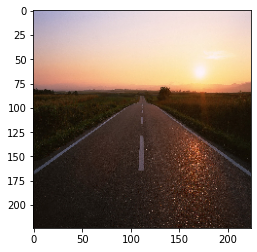

169.pothole2.jpg


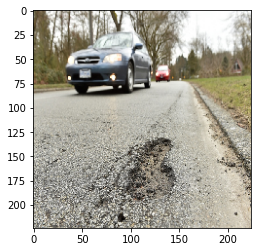

4.Essay-Roads-Featured.jpg


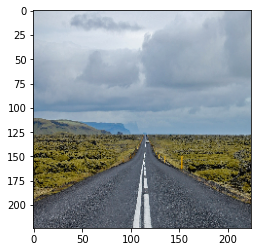

173.10345988.jpg


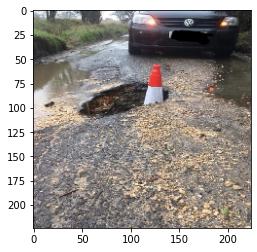

In [10]:
def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)
    print(random_img)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(train_plain_dir)
    show_pictures(train_pothole_dir)

## Obtaining the pre-trained weights from VGG16 for the Convolutional Base

In this project, we want to use a solution based on pre-trained models. We will use models that are composed of two parts:
* Convolutional base.
* Classifier.

Our approach will use the convolutional base to extract features, using them to train a classifier to classify the input image as pothole or plain road. Therefore, the features extracted from the convolutional base will be the same for all classifiers studied in this example.

In [11]:
from keras.applications import VGG16

# Input Shape: (224 X 224 X 3) where 3 is the number of input color channels, RGB
conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

Line by line, what we are doing in VGG16 is:
* **weights** initializes model's weights. Here we are saying that we want to use the same weights as [ImageNet](http://www.image-net.org/). This is smart because we know that our dataset is similar to the ImageNet dataset (i.e. it has dogs and cats).
* **include_top** as false means that we want to train our own classifier on top of the convolutional base. The original VGG16 classifies images according to a set of 1 000 possible classes. Here we are just classifying our images as 'dogs' or 'cats'. 
* **input_shape** defines the shape of the image tensors that will feed the network. We used the default input size of VGG16 (224x224).

We can now check the architecture of the convolutional base that we instantiated.

In [12]:
# Check architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Loading Dataset

Now that we have the convolutional base, we need to pass our images through it for feature extraction.
We use *flow_from_directory* method, the labels are inferred from the directory structure.

In [13]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

Found 420 images belonging to 2 classes.


/usr/lib/python3/dist-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Found 140 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


In [14]:
# Debug
print(train_features)
print(train_labels)

[[[[0.         0.         0.         ... 0.         0.74368238
    0.        ]
   [0.         0.         0.         ... 0.         0.53616673
    0.        ]
   [0.         0.         0.         ... 0.         0.39820436
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.75883156
    0.        ]
   [0.03508979 0.         0.61314559 ... 0.         0.4500415
    0.        ]
   [0.4470641  0.         0.54147333 ... 0.         0.68774694
    0.        ]]

  [[0.11528765 0.         0.         ... 0.         0.64391881
    0.        ]
   [0.27651328 0.         0.         ... 0.         0.64935404
    0.        ]
   [0.16625616 0.         0.14927801 ... 0.         0.62565279
    0.        ]
   ...
   [0.         0.         0.3022607  ... 0.4945263  0.74775201
    0.        ]
   [0.17343372 0.         0.46376812 ... 1.13480055 0.90790653
    0.        ]
   [0.55546278 0.         0.242737   ... 0.85370702 1.20900488
    0.        ]]

  [[0.63231623 0.         0.       

Each sample has a wide range of features and labels are 0 or 1.

Now that we have the features, we can use the three classifiers that we suggest in this project. Accordingly, on top of our convolutional base, we will add a classifier and then our model is ready to make predictions.

In [15]:
train_features.shape

(420, 7, 7, 512)

## Classifier1: Fully Connected Layer Model
### Model Definition

We build a classifier based on fully-connected layers. This classifier will use the features extracted from the convolutional base.

In [16]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [18]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/100
14/14 [==============================] - 1s 66ms/step - loss: 0.9510 - acc: 0.6762 - val_loss: 0.1601 - val_acc: 0.9500
Epoch 2/100
14/14 [==============================] - 1s 38ms/step - loss: 0.1275 - acc: 0.9597 - val_loss: 0.1824 - val_acc: 0.9357
Epoch 3/100
14/14 [==============================] - 1s 38ms/step - loss: 0.1719 - acc: 0.9580 - val_loss: 0.1412 - val_acc: 0.9643
Epoch 4/100
14/14 [==============================] - 0s 35ms/step - loss: 0.0711 - acc: 0.9742 - val_loss: 0.1034 - val_acc: 0.9643
Epoch 5/100
14/14 [==============================] - 1s 36ms/step - loss: 0.0711 - acc: 0.9702 - val_loss: 0.1136 - val_acc: 0.9786
Epoch 6/100
14/14 [==============================] - 1s 102ms/step - loss: 0.0121 - acc: 0.9941 - val_loss: 0.1250 - val_acc: 0.9786
Epoch 7/100
14/14 [==============================] - 2s 115ms/step - loss: 0.0257 - acc: 0.9866 - val_loss: 0.1162 - val_acc: 0.9643
Epoch 8/100
14/14 [==============================] - 1s 36ms/step - loss: 

In [19]:
# Save model
model.save('pothole_fcl.h5')

In [20]:
# from tensorflow import keras
# # Load model
# model = keras.models.load_model('pothole_fcl.h5')

### Classifier1: Fully Connected Layer Model Evaluation

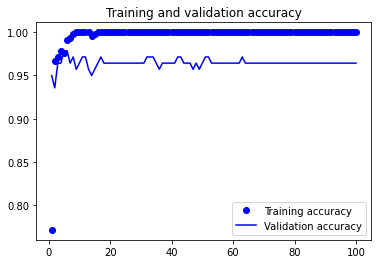

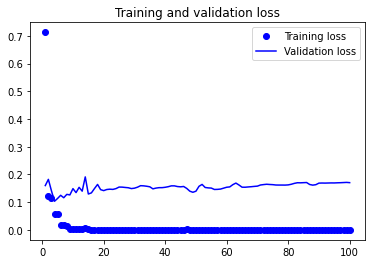

In [21]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Classifier1: Fully Connected Layer Model in Action

In [22]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice([test_plain_dir, test_pothole_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print('Plain')
        else:
            print('Pothole')

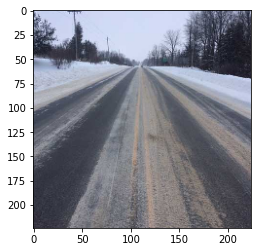

Plain


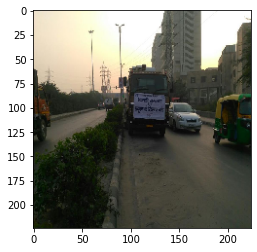

Plain


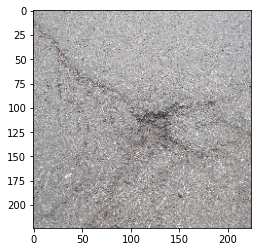

Pothole


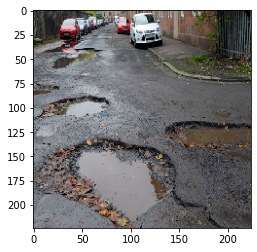

Pothole


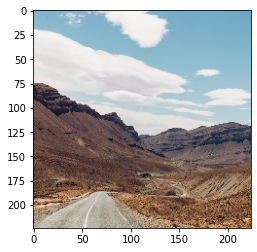

Plain


In [23]:
# Visualize predictions
visualize_predictions(model, 5)

### Classifier1: Fully Connected Layer Model Performance Metrics

In [24]:
# Define function to visualize predictions
def test_output(classifier):
    result = []
    for f in test_features:
      try:
          prediction = classifier.predict(f)
      except:
          prediction = classifier.predict(f.reshape(1, 7, 7, 512))
      if(prediction < 0.5):
        result.append(0)
      else:
        result.append(1)
        
    return result
o = test_output(model)


Confusion Matrix: 
[[69  1]
 [ 2 68]]
Accuracy:  0.9785714285714285
Specificity:  0.9857142857142858
Precision/Positive Predictive Value:  0.9855072463768116
Negative Predictive Value:  0.971830985915493
Recall/Sensitivity:  0.9714285714285714
False Positive Rate:  0.3333333333333333
False Negative Rate:  0.02857142857142857
Positive Likelihood Ratio:  2.9142857142857146
Negative Likelihod Ratio:  0.02898550724637681
Diagnostic Odds Ratio:  100.54285714285716
False Omission Rate:  0.028169014084507043
F1 Score:  0.9784172661870504
Area under ROC curve:  0.9785714285714286


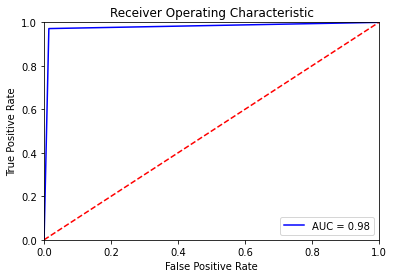

In [25]:
from sklearn.metrics import *
matrix = confusion_matrix(test_labels, o)
print("Confusion Matrix: ")
print(matrix)
[[tn, fp], [fn, tp]] = matrix

acc_score = accuracy_score(test_labels, o)
precision = precision_score(test_labels, o)
recall = tpr = recall_score(test_labels, o)
f1 = f1_score(test_labels, o)
roc_score = roc_auc_score(test_labels, o)
spc = tnr = tn/(tn + fp)
fpr = fp/(fp + fn)
fnr = fn/(fn+tp)
plr = tpr/fpr
nlr = fnr/tnr
dor = plr/nlr
npv = tn/(fn+tn)
fr = fn/(fn+tn)

print("Accuracy: ", acc_score)
print("Specificity: ", spc)
print("Precision/Positive Predictive Value: ", precision)
print("Negative Predictive Value: ", npv)
print("Recall/Sensitivity: ", recall)
print("False Positive Rate: ", fpr)
print("False Negative Rate: ", fnr)
print("Positive Likelihood Ratio: ", plr)
print("Negative Likelihod Ratio: ", nlr)
print("Diagnostic Odds Ratio: ", dor)
print("False Omission Rate: ", fr)
print("F1 Score: ", f1)
print("Area under ROC curve: ", roc_score)


fpr, tpr, threshold = roc_curve(test_labels, o)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Classifier2: Global Average Pooling Model
### Model Definition

The difference between this case and the previous one is that, instead of adding a stack of fully-connected layers, we will add a global average pooling layer and fed its output into a sigmoid activated layer.

We are using the sigmoid activation because in Keras, to perform binary classification, you should use sigmoid activation and binary_crossentropy as the loss.

In [26]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [28]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/100
14/14 [==============================] - 1s 16ms/step - loss: 0.7123 - acc: 0.5117 - val_loss: 0.6734 - val_acc: 0.6357
Epoch 2/100
14/14 [==============================] - 0s 6ms/step - loss: 0.6768 - acc: 0.5847 - val_loss: 0.6403 - val_acc: 0.7500
Epoch 3/100
14/14 [==============================] - 0s 6ms/step - loss: 0.6377 - acc: 0.7716 - val_loss: 0.6102 - val_acc: 0.8429
Epoch 4/100
14/14 [==============================] - 0s 6ms/step - loss: 0.6045 - acc: 0.7886 - val_loss: 0.5833 - val_acc: 0.8857
Epoch 5/100
14/14 [==============================] - 0s 5ms/step - loss: 0.5700 - acc: 0.8589 - val_loss: 0.5580 - val_acc: 0.9143
Epoch 6/100
14/14 [==============================] - 0s 6ms/step - loss: 0.5430 - acc: 0.9063 - val_loss: 0.5374 - val_acc: 0.8929
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 0.5209 - acc: 0.9140 - val_loss: 0.5158 - val_acc: 0.9071
Epoch 8/100
14/14 [==============================] - 0s 5ms/step - loss: 0.5013 - 

In [29]:
# Save model
model.save('pothole_gap.h5')

In [30]:
# from tensorflow import keras
# # Load model
# model = keras.models.load_model('pothole_gap.h5')

### Classifier2: Global Average Pooling Model Evaluation

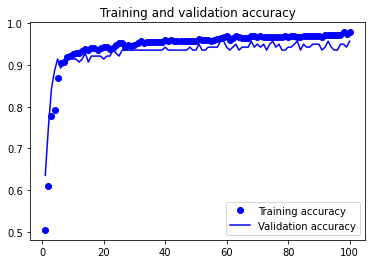

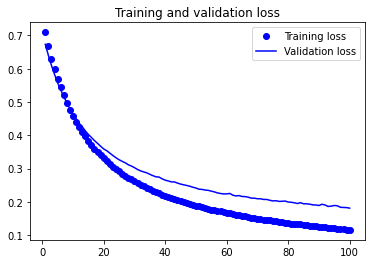

In [31]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Classifier2: Global Average Pooling Model in Action

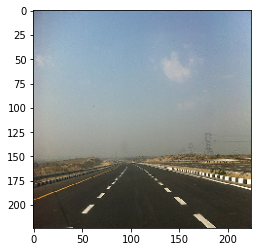

Plain


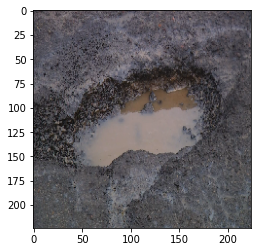

Pothole


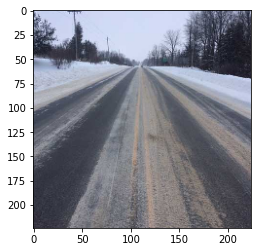

Plain


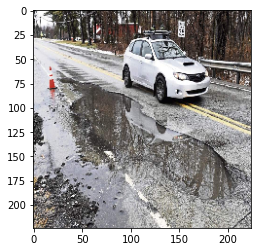

Pothole


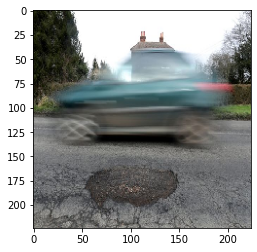

Pothole


In [32]:
# Visualize predictions
visualize_predictions(model, 5)

### Classifier2: Global Average Pooling Model Performance Metrics

In [33]:
# Define function to visualize predictions
def test_output(classifier):
    result = []
    for f in test_features:
      try:
          prediction = classifier.predict(f)
      except:
          prediction = classifier.predict(f.reshape(1, 7, 7, 512))
      if(prediction < 0.5):
        result.append(0)
      else:
        result.append(1)
        
    return result
o = test_output(model)


Confusion Matrix: 
[[67  3]
 [ 5 65]]
Accuracy:  0.9428571428571428
Specificity:  0.9571428571428572
Precision/Positive Predictive Value:  0.9558823529411765
Negative Predictive Value:  0.9305555555555556
Recall/Sensitivity:  0.9285714285714286
False Positive Rate:  0.375
False Negative Rate:  0.07142857142857142
Positive Likelihood Ratio:  2.4761904761904763
Negative Likelihod Ratio:  0.07462686567164178
Diagnostic Odds Ratio:  33.180952380952384
False Omission Rate:  0.06944444444444445
F1 Score:  0.9420289855072465
Area under ROC curve:  0.9428571428571428


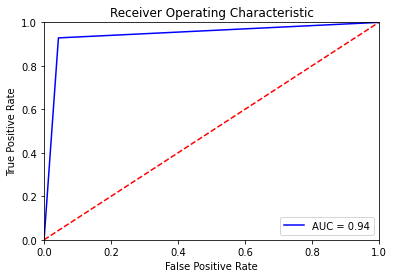

In [34]:
from sklearn.metrics import *
matrix = confusion_matrix(test_labels, o)
print("Confusion Matrix: ")
print(matrix)
[[tn, fp], [fn, tp]] = matrix

acc_score = accuracy_score(test_labels, o)
precision = precision_score(test_labels, o)
recall = tpr = recall_score(test_labels, o)
f1 = f1_score(test_labels, o)
roc_score = roc_auc_score(test_labels, o)
spc = tnr = tn/(tn + fp)
fpr = fp/(fp + fn)
fnr = fn/(fn+tp)
plr = tpr/fpr
nlr = fnr/tnr
dor = plr/nlr
npv = tn/(fn+tn)
fr = fn/(fn+tn)

print("Accuracy: ", acc_score)
print("Specificity: ", spc)
print("Precision/Positive Predictive Value: ", precision)
print("Negative Predictive Value: ", npv)
print("Recall/Sensitivity: ", recall)
print("False Positive Rate: ", fpr)
print("False Negative Rate: ", fnr)
print("Positive Likelihood Ratio: ", plr)
print("Negative Likelihod Ratio: ", nlr)
print("Diagnostic Odds Ratio: ", dor)
print("False Omission Rate: ", fr)
print("F1 Score: ", f1)
print("Area under ROC curve: ", roc_score)


fpr, tpr, threshold = roc_curve(test_labels, o)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Classifier3: Linear Support Vector Machine Model
### Model Definition

In this case, we will train a linear SVM classifier on the features extracted by the convolutional base. To train this classifier, a traditional machine learning approach is preferable. Accordingly, we will use k-fold cross-validation to estimate the error of the classifier. Since k-fold cross-validation will be used, we can concatenate the train and the validation sets to enlarge our training data (we keep the test set untouched, as we did in the previous cases).

In [35]:
# Concatenate training and validation sets
svm_features = np.concatenate((train_features, validation_features))
svm_labels = np.concatenate((train_labels, validation_labels))

In [36]:
svm_labels

array([1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0.,
       1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 1., 0., 0.

In [37]:
svm_features.shape

(560, 7, 7, 512)

The SVM classifier has one hyperparameter. This hyperparameter is the penalty parameter C of the error term. To optimize the choice of this hyperparameter, we will use [exhaustive grid search](http://scikit-learn.org/stable/modules/grid_search.html#grid-search).

In [38]:
# Build model
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

X_train, y_train = svm_features.reshape(560,7*7*512), svm_labels

param = [{
          "C": [0.01, 0.1, 1, 10, 100]
         }]
 
svm = LinearSVC(penalty='l2', loss='squared_hinge',max_iter=10000)  # As in Tang (2013)
clf = GridSearchCV(svm, param, cv=10,verbose=10)
clf.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10; 1/5] START C=0.01.....................................................
[CV 1/10; 1/5] END ...................................C=0.01; total time=   5.7s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   4.2s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   5.5s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   4.6s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   2.7s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END .............................

GridSearchCV(cv=10, estimator=LinearSVC(max_iter=10000),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}], verbose=10)

In [39]:
# Save model
import joblib
joblib.dump(clf, 'pothole_svm.pkl')

['pothole_svm.pkl']

In [40]:
# Load model
# clf = joblib.load('pothole_svm.h5')

In [41]:
clf

GridSearchCV(cv=10, estimator=LinearSVC(max_iter=10000),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}], verbose=10)

### Classifier3: Linear Support Vector Machine Model Evaluation

In [42]:
# Evaluate model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

print("\nAccuracy score (mean):")
acc_mean = np.mean(cross_val_score(clf, X_train, y_train, cv=10,verbose=10))
# print(cvss)

print("\nAccuracy score (standard deviation):")
acc_std = np.std(cross_val_score(clf, X_train, y_train, cv=10,verbose=10))
# print(asss)


Accuracy score (mean):
[CV] START .....................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10; 1/5] START C=0.01.....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.1s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   1.2s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.4s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   4.3s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   2.8s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   3.6s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.1s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   2.4s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.8s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.5s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.3s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   2.7s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 7/10; 3/5] END ......................................C=1; total time=  42.2s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.6s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   2.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.2min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.5s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   2.0s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   3.9s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.5s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.1s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   2.9s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.6min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.8s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   3.4s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   3.8s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   4.4s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   4.1s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   3.6s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 15.6min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.2s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   3.7s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   1.2s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   3.3s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   3.1s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   4.3s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 10/10; 3/5] END .....................................C=1; total time=  36.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.5s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.7s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .........

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 19.5min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.7s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   2.9s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.8s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.6s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   2.5s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   2.3s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 27.9min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   6.1s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   6.2s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.9s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   7.7s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   9.3s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=  10.0s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/10; 3/5] END ......................................C=1; total time= 1.2min
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   1.6s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   3.6s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   2.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=  32.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   9.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 38.0min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.9s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   8.8s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   3.5s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   8.9s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   9.2s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   7.7s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/10; 3/5] END ......................................C=1; total time= 1.3min
[CV 3/10; 3/5] START C=1........................................................
[CV 3/10; 3/5] END ......................................C=1; total time=   1.7s
[CV 4/10; 3/5] START C=1........................................................
[CV 4/10; 3/5] END ......................................C=1; total time=   1.6s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=  23.7s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   2.1s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time= 1.1min
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END .........

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 49.2min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.3s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   2.5s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   7.1s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.0s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   3.5s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   1.1s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 54.1min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   3.7s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   7.2s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   4.1s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   6.6s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   6.9s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   2.2s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 7/10; 3/5] END ......................................C=1; total time= 1.2min
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=  26.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=  24.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   2.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   8.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 63.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.9s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   3.7s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   3.0s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   3.1s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   2.8s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   1.3s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.7min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.4s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   4.0s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   4.4s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   3.6s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   5.4s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   3.9s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 15.3min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.0s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   2.5s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   7.9s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   6.4s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   5.4s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   3.0s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.1min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.7s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   6.5s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   3.9s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.2s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   6.2s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   3.6s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 10/10; 3/5] END .....................................C=1; total time= 1.8min
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.9s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   9.0s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   1.8s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .........

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 29.4min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.8s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   3.8s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   1.2s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   4.9s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.3s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   2.7s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 37.1min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=  12.9s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   4.5s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   7.0s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.4s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   8.5s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   7.9s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 44.3min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.3s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   2.5s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.7s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.6s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   2.8s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   2.5s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 48.0min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.5s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   2.8s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.0s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   3.1s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   2.7s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   2.6s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/10; 3/5] END ......................................C=1; total time=  33.8s
[CV 3/10; 3/5] START C=1........................................................
[CV 3/10; 3/5] END ......................................C=1; total time=   1.9s
[CV 4/10; 3/5] START C=1........................................................
[CV 4/10; 3/5] END ......................................C=1; total time=  27.0s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=  13.9s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.5s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END .........

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 52.8min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.2s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   2.2s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.4s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.2s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   2.5s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   1.1s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 55.5min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.7s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   2.8s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.3s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   3.0s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   2.4s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   2.1s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 59.6min finished


In [43]:
print("Accuracy score (mean) :", acc_mean)
print("\nAccuracy score (standard deviation) :", acc_std)

Accuracy score (mean) : 0.9678571428571429

Accuracy score (standard deviation) : 0.02743266338524501


In [44]:
# Plot learning curves
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator = clf,
                                                        X = X_train,
                                                        y = y_train,
                                                        train_sizes = np.linspace(0.1,1.0,10),
                                                        cv = 10,verbose=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


[learning_curve] Training set sizes: [ 50 100 151 201 252 302 352 403 453 504]
[CV] START .....................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10; 1/5] START C=0.01.....................................................
[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.2s
[CV 2/10; 1/5] START C=0.01.....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/10; 1/5] END ...................................C=0.01; total time=   0.1s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   0.1s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.1s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.1s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.1s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END ...................................C=0.01; total time=   0.1s
[CV 8/10; 1/5] START C=0.01.....................................................
[CV 8/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.3s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   0.2s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   0.3s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.3s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.3s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.3s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.6s remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.6s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   0.6s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   0.5s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.6s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.5s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.6s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.6s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   0.6s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   0.6s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.6s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.6s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.5s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.6s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   1.5s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   0.7s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.7s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.5s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.7s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   0.9s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.6s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.7s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.7s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.0min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.9s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   0.9s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.7s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.0s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.9min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.0s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   0.9s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   0.9s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.9s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.9s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   1.0s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.8min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.5s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   1.3s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   1.5s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.5s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   3.0s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   2.4s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  7.3min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.4s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   1.1s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.5s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   1.9s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   2.6s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   2.0s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 7/10; 3/5] END ......................................C=1; total time=  30.6s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   6.3s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.8s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=  26.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   3.4s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   2.9s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.7s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   2.8s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   3.7s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.6s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/10; 3/5] END ......................................C=1; total time=  31.5s
[CV 4/10; 3/5] START C=1........................................................
[CV 4/10; 3/5] END ......................................C=1; total time=   1.6s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.5s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END .........

[CV 3/10; 3/5] END ......................................C=1; total time=   4.8s
[CV 4/10; 3/5] START C=1........................................................
[CV 4/10; 3/5] END ......................................C=1; total time=   1.8s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   1.5s
[CV 6/10; 3/5] START C=1........................................................


/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 6/10; 3/5] END ......................................C=1; total time=  33.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.5s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=  27.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.7s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   2.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=  11.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.7s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.6s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   2.1s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   7.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   6.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   7.8s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.8s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   1.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=  15.3s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   2.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=  13.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.5s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.7s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   3.3s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.6s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=  13.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=  23.7s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   4.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=  13.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   2.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   7.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 6/10; 3/5] END ......................................C=1; total time=  31.3s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=  23.6s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=  17.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 6/10; 3/5] END ......................................C=1; total time=  34.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=  15.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   5.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=  11.9s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/10; 3/5] END ......................................C=1; total time=  39.7s
[CV 3/10; 3/5] START C=1........................................................
[CV 3/10; 3/5] END ......................................C=1; total time=   2.3s
[CV 4/10; 3/5] START C=1........................................................
[CV 4/10; 3/5] END ......................................C=1; total time=   3.9s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   2.1s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   2.1s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   2.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END .........

[CV 2/10; 3/5] END ......................................C=1; total time=   1.7s
[CV 3/10; 3/5] START C=1........................................................
[CV 3/10; 3/5] END ......................................C=1; total time=   1.5s
[CV 4/10; 3/5] START C=1........................................................
[CV 4/10; 3/5] END ......................................C=1; total time=  18.8s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=  18.3s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   1.6s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.8s
[CV 8/10; 3/5] START C=1........................................................


/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 8/10; 3/5] END ......................................C=1; total time=  35.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   2.1s
[CV 10/10; 3/5] START C=1.......................................................


/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 10/10; 3/5] END .....................................C=1; total time=  37.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   3.4s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.8s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   1.9s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

[CV 1/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .....................................C=10; total time=   1.6s
[CV 6/10; 4/5] START C=10.......................................................
[CV 6/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 7/10; 4/5] START C=10.......................................................
[CV 7/10; 4/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 7/10; 3/5] END ......................................C=1; total time=  35.5s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.7s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=  20.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   3.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.6s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.7s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.7s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=  29.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   5.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

/home/admin/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 7/10; 3/5] END ......................................C=1; total time=  34.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=  27.9s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=  16.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 136.6min finished


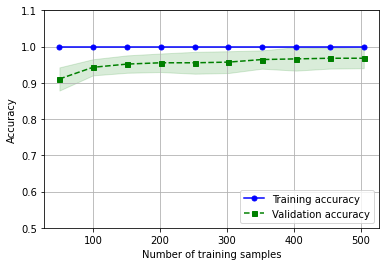

In [45]:
plt.plot(train_sizes, train_mean, color='blue', 
         marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')


plt.plot(train_sizes, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.1])
plt.show()

### Classifier3: Linear Support Vector Machine Model in Action

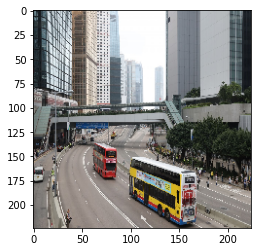

Plain


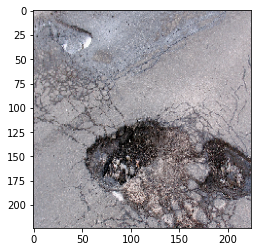

Pothole


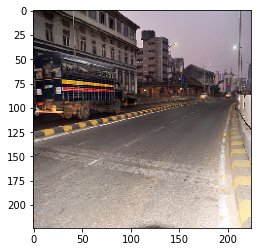

Plain


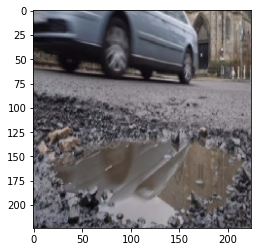

Pothole


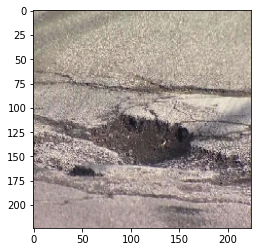

Pothole


In [46]:
# Visualize predictions
visualize_predictions(clf, 5)

### Classifier3: Linear Support Vector Machine Model Performance Metrics

In [47]:
# Define function to visualize predictions
def test_output(classifier):
    result = []
    for f in test_features:
      try:
          prediction = classifier.predict(f)
      except:
          prediction = classifier.predict(f.reshape(1, 7*7*512))
      if(prediction < 0.5):
        result.append(0)
      else:
        result.append(1)
        
    return result
o = test_output(clf)


Confusion Matrix: 
[[68  2]
 [ 3 67]]
Accuracy:  0.9642857142857143
Specificity:  0.9714285714285714
Precision/Positive Predictive Value:  0.9710144927536232
Negative Predictive Value:  0.9577464788732394
Recall/Sensitivity:  0.9571428571428572
False Positive Rate:  0.4
False Negative Rate:  0.04285714285714286
Positive Likelihood Ratio:  2.392857142857143
Negative Likelihod Ratio:  0.04411764705882353
Diagnostic Odds Ratio:  54.238095238095234
False Omission Rate:  0.04225352112676056
F1 Score:  0.9640287769784173
Area under ROC curve:  0.9642857142857144


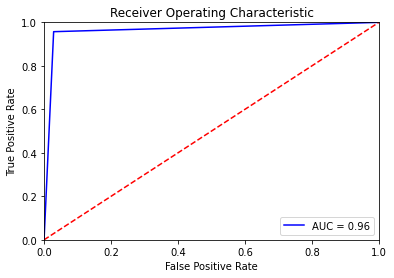

In [48]:
from sklearn.metrics import *
matrix = confusion_matrix(test_labels, o)
print("Confusion Matrix: ")
print(matrix)
[[tn, fp], [fn, tp]] = matrix

acc_score = accuracy_score(test_labels, o)
precision = precision_score(test_labels, o)
recall = tpr = recall_score(test_labels, o)
f1 = f1_score(test_labels, o)
roc_score = roc_auc_score(test_labels, o)
spc = tnr = tn/(tn + fp)
fpr = fp/(fp + fn)
fnr = fn/(fn+tp)
plr = tpr/fpr
nlr = fnr/tnr
dor = plr/nlr
npv = tn/(fn+tn)
fr = fn/(fn+tn)

print("Accuracy: ", acc_score)
print("Specificity: ", spc)
print("Precision/Positive Predictive Value: ", precision)
print("Negative Predictive Value: ", npv)
print("Recall/Sensitivity: ", recall)
print("False Positive Rate: ", fpr)
print("False Negative Rate: ", fnr)
print("Positive Likelihood Ratio: ", plr)
print("Negative Likelihod Ratio: ", nlr)
print("Diagnostic Odds Ratio: ", dor)
print("False Omission Rate: ", fr)
print("F1 Score: ", f1)
print("Area under ROC curve: ", roc_score)


fpr, tpr, threshold = roc_curve(test_labels, o)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Summary

In this example we:
* Showed how to use transfer learning to solve image classification problems.
* Used a pre-trained convolutional neural network model to extract features from pictures.
* Fed those features into different classifiers to build a prediction model.
* Tested classifiers based on fully-connected layers, global average pooling, and linear support vector machines.